<div class="output_png output_subarea output_execute_result">
<center>
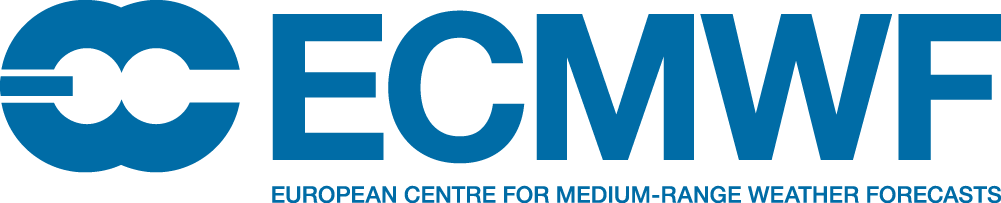
</div>

# Experimental: AIFS (ECMWF) ML model: Mean sea level pressure and 200 hPa wind

This notebook will provide you guidance how to explore and plot ECMWF AIFS open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/aifs_medium-mslp-wind200  


<div class="output_png output_subarea output_execute_result">
<center>
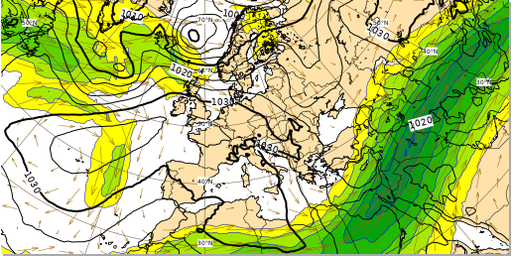</center>
</div>

The full list of available AIFS Open data products can be found [here](https://www.ecmwf.int/en/forecasts/dataset/aifs-machine-learning-data), and more information can be found in the [User documentation](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts+from+IFS+and+AIFS+from+IFS+and+AIFS).  

Access to ECMWF AIFS data is governed by the Creative Commons CC-BY-4.0 licence and associated [Terms of Use](https://apps.ecmwf.int/datasets/licences/general/).  

<sub> In applying this licence, ECMWF does not waive the privileges and immunities granted to it by virtue of its status as an intergovernmental organisation nor does it submit to any jurisdiction </sub>

To find out how to obtain the access to the full forecast dataset [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 3 parameters :

* [Mean sea level pressure](https://codes.ecmwf.int/grib/param-db/151)
* [U component of wind at 200 hPa](https://codes.ecmwf.int/grib/param-db/131)
* [V component of wind  at 200 hPa](https://codes.ecmwf.int/grib/param-db/132)

In this example, we will use: 
- [**ecmwf.opendata**](https://github.com/ecmwf/ecmwf-opendata) Client to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#!pip install ecmwf-opendata metview metview-python

In [1]:
import metview as mv
from ecmwf.opendata import Client

In [2]:
client = Client("ecmwf", beta=False)

## Retrieve requests
This product uses parameters at different vertical levels.  
Mean sea level pressure belongs to the surface parameters, while u and v at 200 hPa are pressure level parameters.  
The two types of levels can not be in the same request, so we need to make two requests for them. 

In [3]:
sfc_parameters = ['msl']
pl_parameters = ['u', 'v']
sfc_filename = 'aifs_medium-mslp-wind200-sfc.grib'
pl_filename = 'aifs_medium-mslp-wind200-pl.grib'

Setting date to 0 will download today's data. 
Removing date and time altogether from the request will download the latest data.  
Try commenting out date and time to download latest forecast!

In [4]:
client.retrieve(
    date=0,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="sfc",
    model="aifs-single",
    param=sfc_parameters,
    target=sfc_filename
)

20250226000000-12h-oper-fc.grib2:   0%|          | 0.00/592k [00:00<?, ?B/s]

In [5]:
client.retrieve(
    date=0,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=200,
    param=pl_parameters,
    model="aifs-single",
    target=pl_filename
)

20250226000000-12h-oper-fc.grib2:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

## Reading and processing the data
Now we can use **Metview's read() function** to read the files.

In [6]:
wind200 = mv.read(pl_filename)
msl = mv.read(sfc_filename)

The **describe()** function will give us the overview of the dataset.  

In [7]:
wind200.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
u,isobaricInhPa,200,20250226,0,12,None,131,ai,oper,fc,0001
v,isobaricInhPa,200,20250226,0,12,None,132,ai,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [8]:
msl.describe('msl')

shortName,msl
name,Mean sea level pressure
paramId,151
units,Pa
typeOfLevel,meanSea
level,0
date,20250226
time,0
step,12
number,None
class,ai


We can use **ls()** function to list all the fields in the file we downloaded.

In [9]:
wind200.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,u,isobaricInhPa,200,20250226,0,12,fc,None,regular_ll
1,ecmf,v,isobaricInhPa,200,20250226,0,12,fc,None,regular_ll


In order to calculate the speed, we need to filter out u and v component and use the **speed()** function for the calculation.

In [10]:
u = wind200.select(shortName ='u')
v = wind200.select(shortName ='v')
speed = mv.speed(u,v)
speed.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
ws,isobaricInhPa,200,20250226,0,12,None,10,ai,oper,fc,0001


Mean sea level pressure data has unites Pa, but we want to plot it in hPa, therefore we need to convert it.

In [11]:
msl /= 100

And finally, we can plot the data on the map. 

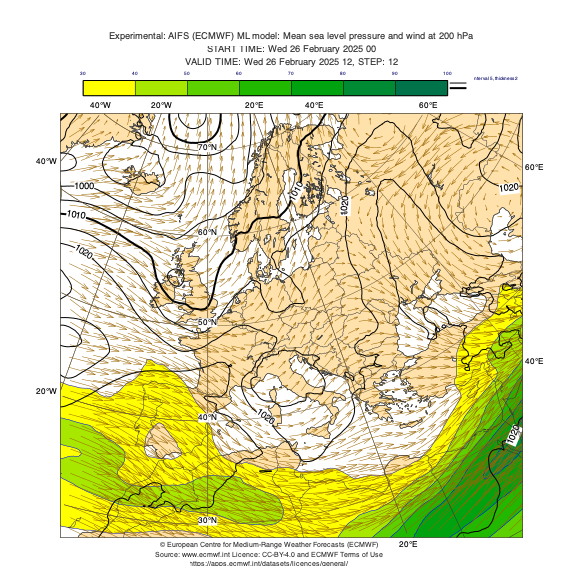

In [12]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    subpage_clipping="on",
    coastlines=coast
)

#define styles
speed_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_grn_f30t100i10")

mslp_contour = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "ct_blk_i5_t2")

wind_arrows = mv.mwind(
    wind_thinning_factor=5, wind_arrow_colour="mustard"
)

title = mv.mtext(
    text_lines=["Experimental: AIFS (ECMWF) ML model: Mean sea level pressure and wind at 200 hPa", 
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=msl' /> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=msl' />, STEP: <grib_info key='step' where='shortName=msl' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, speed, speed_shade, wind200, wind_arrows, msl, mslp_contour, title, ecmwf_text)

To generate the png file you can run the following cell.

In [13]:
png = mv.png_output(
      output_name = "aifs_medium-mslp-wind200",   # specify relative or full path
      output_title = "aifs_medium-mslp-wind200",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, speed, speed_shade, wind200, wind_arrows, msl, mslp_contour, title, ecmwf_text)